In [ ]:

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Plot defaults (optional)
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300
})


# ---- Paths (EDIT THESE) ----
validators_csv = Path("data/validators.csv")    # expects latitude, longitude, validator_count
regions_csv    = Path("data/gcp_regions.csv")   # expects Region, Nearest City Latitude, Nearest City Longitude
latency_csv    = Path("data/gcp_latency.csv")       # expects sending_region, receiving_region, milliseconds

outdir = Path("figures")
outdir.mkdir(parents=True, exist_ok=True)

world_json = Path("data/world_countries.geo.json")

# ---- Output settings ----
fmt = "png"   # choices: "png", "pdf", "svg"
dpi = 300
label_regions = False

FIG_SIZE = (8, 6)
FIG_SIZE_2 = (6.8, 5.6)  # for subregion latency map
# FIG_SIZE_WIDE = (10, 6)

In [ ]:

def ensure_world_geojson(local_path: Path):
    """Ensure a light world countries GeoJSON exists at local_path.
    Tries to download from GitHub if missing.
    """
    if local_path.is_file():
        return
    local_path.parent.mkdir(parents=True, exist_ok=True)
    url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
    try:
        import urllib.request
        with urllib.request.urlopen(url) as resp:
            world = json.load(resp)
        with open(local_path, "w") as f:
            json.dump(world, f)
        print(f"Downloaded world GeoJSON to {local_path}")
    except Exception as e:
        print("⚠️ Could not download world GeoJSON. Please place a GeoJSON at:", local_path)
        print("Error:", e)

def draw_world_outline(ax, world_geojson_path: Path, line_color="#888888", lw=0.4):
    """Very lightweight plate carrée (lon=x, lat=y) country outlines from GeoJSON."""
    with open(world_geojson_path, "r") as f:
        world = json.load(f)

    for feat in world.get("features", []):
        geom = feat.get("geometry")
        if geom is None:
            continue
        gtype = geom.get("type")
        coords = geom.get("coordinates", [])

        if gtype == "Polygon":
            polys = [coords]
        elif gtype == "MultiPolygon":
            polys = coords
        else:
            continue

        for poly in polys:
            if not poly:
                continue
            ring = poly[0]
            if len(ring) < 2:
                continue
            lons, lats = zip(*ring)
            ax.plot(lons, lats, color=line_color, linewidth=lw, alpha=0.8)

    # nice bounds
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect(1 / np.cos(np.deg2rad(0)))  # keep basic aspect reasonable

def save_fig(fig, out: Path, fmt: str, dpi: int):
    out = out.with_suffix(f".{fmt}")
    fig.tight_layout()
    fig.savefig(out, dpi=dpi)
    if fmt.lower() != "pdf":
        fig.savefig(out.with_suffix(".pdf"))
    print("✓ Saved", out)
    # Show the figure
    plt.show()

ensure_world_geojson(world_json)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def figure_validators_simple(
    validators_csv: Path,
    outpath: Path,
    fmt: str,
    dpi: int,
    relays: list = None,
    point_size=30,
    point_alpha=0.6,
):
    """
    Simple unweighted validator distribution (scatter dots).
    Overlays relay nodes with star markers.
    Uses Cartopy for proper geographic ticks and gridlines.
    """
    df = pd.read_csv(validators_csv)

    lats = df["latitude"].to_numpy(dtype=float)
    lons = df["longitude"].to_numpy(dtype=float)

    # Create cartopy map
    fig = plt.figure(figsize=FIG_SIZE, dpi=dpi)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines(linewidth=0.5, color="gray")
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor="gray")

    # Validator scatter
    ax.scatter(
        lons, lats,
        s=point_size,
        c="darkgreen",
        alpha=point_alpha,
        marker="o",
        transform=ccrs.PlateCarree(),
        zorder=1,
        label="Validators"
    )

    # Relays overlay
    if relays:
        for relay in relays:
            ax.scatter(
                relay["lon"], relay["lat"],
                s=150,
                c="red",
                marker="*",
                edgecolors="k",
                linewidths=0.8,
                transform=ccrs.PlateCarree(),
                zorder=2,
                label=relay["unique_id"]
            )

    # Legend without duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="lower left", fontsize=10)

    # Add ticks + gridlines
    xticks = np.arange(-180, 181, 60)
    yticks = np.arange(-90, 91, 30)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # Set axis tick size
    ax.tick_params(axis='both', which='major', labelsize=10)

    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.3, linestyle="--")
    gl.xlocator = plt.MultipleLocator(60)
    gl.ylocator = plt.MultipleLocator(30)

    ax.set_title("Ethereum Validator Distribution with MEV-Boost Relay Nodes", fontsize=12)
    save_fig(fig, outpath, fmt, dpi)
    plt.close(fig)


relays = [
    {"unique_id": "Relay", "lat": 39.0437, "lon": -77.4874},
    {"unique_id": "Relay", "lat": 50.4577, "lon": 3.8643},
]

figure_validators_simple(
    validators_csv=Path("data/validators.csv"),
    outpath=Path("latency_figures/validators_simple_with_relays"),
    fmt="pdf",
    dpi=300,
    relays=relays
)



## Configure paths and output settings

- Set your CSV paths below.
- Choose the output format (`png`, `pdf`, or `svg`) and DPI.
- The world GeoJSON will be placed at `data/world_countries.geo.json` by default.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

_CONTINENT_RULES = [
    (r"^us-|^northamerica-", "North America"),
    (r"^southamerica-",      "South America"),
    (r"^europe-",            "Europe"),
    (r"^asia-",              "Asia"),
    (r"^australia-",         "Oceania"),
    (r"^me-",                "Middle East"),
    (r"^africa-",            "Africa"),
]

def to_continent(region: str) -> str:
    for pat, name in _CONTINENT_RULES:
        if re.match(pat, region):
            return name
    return "Other"

def latency_continent_heatmap_unique(
    regions_csv,
    latency_csv,
    outpath=None,
    dpi=300,
    order=("North America", "Europe"),   # 👈 highlight these first by default
    triangle="upper"                     # "lower" or "upper"
):
    regions = pd.read_csv(regions_csv)
    latency = pd.read_csv(latency_csv)

    reg_ids = set(regions["Region"])
    latency = latency[
        latency["sending_region"].isin(reg_ids) &
        latency["receiving_region"].isin(reg_ids)
    ].copy()

    regions["Continent"] = regions["Region"].map(to_continent)
    cont_map = dict(zip(regions["Region"], regions["Continent"]))
    latency["from_c"] = latency["sending_region"].map(cont_map)
    latency["to_c"]   = latency["receiving_region"].map(cont_map)

    # Undirected mean per continent pair
    latency["pair"] = latency.apply(
        lambda r: tuple(sorted([r["from_c"], r["to_c"]])), axis=1
    )
    c_lat = latency.groupby("pair")["milliseconds"].mean().reset_index()

    # Build symmetric matrix
    mat = {}
    for _, row in c_lat.iterrows():
        a, b = row["pair"]; ms = row["milliseconds"]
        mat.setdefault(a, {})[b] = ms
        mat.setdefault(b, {})[a] = ms
    df = pd.DataFrame(mat)

    # ------- ordering -------
    # Options:
    #  - order is tuple/list: treat as "focus set"; put them first, then the rest
    #    sorted by mean latency TO the focus set (ascending).
    #  - order == "mean-asc": sort all by overall mean latency (ascending).
    #  - order is None: keep raw order.
    cols = df.columns.tolist()
    if isinstance(order, (list, tuple)):
        focus = [c for c in order if c in cols]
        rest  = [c for c in cols if c not in focus]
        if focus:
            # mean latency to the focus set; NaNs pushed to end
            def key_fn(c):
                try:
                    return np.nanmean(df.loc[c, focus].to_numpy())
                except Exception:
                    return np.inf
            rest_sorted = sorted(rest, key=key_fn)
            idx = [*focus, *rest_sorted]
        else:
            idx = cols
    elif isinstance(order, str) and order == "mean-asc":
        idx = df.mean(axis=1).sort_values().index.tolist()
    else:
        idx = cols

    # reindex with the chosen order (drop any missing)
    idx = [c for c in idx if c in df.index or c in df.columns]
    df = df.reindex(index=idx, columns=idx)

    # ------- mask one triangle + diagonal -------
    n = len(df.index)
    mask = np.zeros((n, n), dtype=bool)
    if triangle == "lower":
        mask[np.tril_indices(n)] = True
    else:
        mask[np.triu_indices(n)] = True

    # ------- plot -------
    plt.figure(figsize=(6.8, 5.6))
    sns.heatmap(
        df, cmap="viridis_r", annot=True, fmt=".0f", square=True,
        cbar_kws={"label": "Latency (ms)"}, mask=mask
    )
    plt.title("Inter-Continent Average Latency (unique pairs)")
    plt.xlabel("Receiving Continent")
    plt.ylabel("Sending Continent")
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=dpi)
        print("✓ saved", outpath)
    plt.show()


latency_continent_heatmap_unique(
    regions_csv="data/gcp_regions.csv",
    latency_csv="data/gcp_latency.csv",
    outpath="latency_figures/gcp_continent_latency_heatmap.pdf"
)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geographiclib.geodesic import Geodesic
import re
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def simplify_region(region_name):
    """Collapse region IDs like 'us-east4' -> 'us-east', 'europe-west3' -> 'europe-west'."""
    m = re.match(r"([a-z]+-[a-z]+)", region_name)
    return m.group(1) if m else region_name

def figure_subregion_latency_map(regions_csv, latency_csv, outpath=None,
                                 fmt="png", dpi=300, cmap="plasma",
                                 node_size=80, top_frac=0.5, label=True):
    regions = pd.read_csv(regions_csv)
    latency = pd.read_csv(latency_csv)

    # Add subregion labels
    regions["SubRegion"] = regions["Region"].map(simplify_region)
    sub_map = dict(zip(regions["Region"], regions["SubRegion"]))

    latency["Sub_from"] = latency["sending_region"].map(sub_map)
    latency["Sub_to"] = latency["receiving_region"].map(sub_map)

    # Aggregate latency by subregion pairs
    latency["pair"] = latency.apply(
        lambda r: tuple(sorted([r["Sub_from"], r["Sub_to"]])), axis=1
    )
    sub_latency = latency.groupby("pair")["milliseconds"].mean().reset_index()

    # Assign representative coordinates: mean of member regions
    rep_coords = regions.groupby("SubRegion")[["Nearest City Longitude","Nearest City Latitude"]].mean()

    # Keep only top N% lowest latency edges
    k = int(len(sub_latency) * top_frac)
    sub_latency = sub_latency.nsmallest(k, "milliseconds")

    # Restrict rep_coords to only connected subregions
    connected = set([s1 for pair in sub_latency["pair"] for s1 in pair])
    rep_coords = rep_coords.loc[rep_coords.index.intersection(connected)]

    # Colormap
    vals = sub_latency["milliseconds"].to_numpy()
    norm = Normalize(vmin=vals.min(), vmax=vals.max())
    sm = ScalarMappable(norm=norm, cmap=cmap)

    # Plot
    fig = plt.figure(figsize=(8, 6), dpi=dpi)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines(linewidth=0.5, color="gray")
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor="gray")

    geod = Geodesic.WGS84
    for _, row in sub_latency.iterrows():
        s1, s2 = row["pair"]
        lon1, lat1 = rep_coords.loc[s1]
        lon2, lat2 = rep_coords.loc[s2]
        line = geod.InverseLine(lat1, lon1, lat2, lon2)
        npoints = 50
        lons, lats = [], []
        for i in np.linspace(0, line.s13, npoints):
            g = line.Position(i)
            lats.append(g["lat2"])
            lons.append(g["lon2"])

        # --- NEW: split at dateline
        lons = np.unwrap(np.radians(lons), discont=np.pi)
        lons = np.degrees(lons)
        ax.plot(lons, lats, color=sm.to_rgba(row["milliseconds"]),
                linewidth=1, alpha=0.9, transform=ccrs.PlateCarree())

    # Draw nodes (subregions)
    ax.scatter(rep_coords["Nearest City Longitude"], rep_coords["Nearest City Latitude"],
               s=node_size, c="black", transform=ccrs.PlateCarree(), zorder=3)

    # Add lat/lon ticks and gridlines
    xticks = np.arange(-180, 181, 60)
    yticks = np.arange(-90, 91, 30)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Gridlines matching ticks
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.3, linestyle="--")
    gl.xlocator = plt.MultipleLocator(60)
    gl.ylocator = plt.MultipleLocator(30)


    cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
    cbar.set_label("Average Latency (ms)")

    ax.set_title(f"Top {int(top_frac*100)}% Lowest-Latency Corridors Between GCP Regions")
    if outpath:
        plt.savefig(outpath, dpi=dpi, bbox_inches="tight")
        print("✓ saved", outpath)
    plt.show()

figure_subregion_latency_map(
    regions_csv="data/gcp_regions.csv",
    latency_csv="data/gcp_latency.csv",
    outpath="latency_figures/gcp_subregion_latency_map.pdf"
)


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as pe

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from geographiclib.geodesic import Geodesic

# -------- continent mapping --------
_CONTINENT_RULES = [
    (r"^us-|^northamerica-", "North America"),
    (r"^southamerica-",      "South America"),
    (r"^europe-",            "Europe"),
    (r"^asia-",              "Asia"),
    (r"^australia-",         "Oceania"),
    (r"^me-",                "Middle East"),
    (r"^africa-",            "Africa"),
]
def to_continent(region: str) -> str:
    for pat, name in _CONTINENT_RULES:
        if re.match(pat, region):
            return name
    return "Other"

# -------- main figure --------
def figure_continent_backbone_map(
    regions_csv: str,
    latency_csv: str,
    outpath: str | None = None,
    fmt: str = "png",
    dpi: int = 300,
    cmap: str = "plasma",
    node_size: int = 120,
    label_nodes: bool = True,
    label_arcs: bool = True,
    lw_min: float = 0.8,
    lw_max: float = 4.0,
    highlight_pairs: list | None = None,  # e.g. [("North America","Europe")]
):
    """
    Continent-level latency backbone:
      - One node per continent (mean of member region coordinates)
      - Great-circle arcs between continents (inter only)
      - Color = average latency (ms)
      - Line width ∝ 1/latency (fast corridors look thicker)
      - Only shows continents that appear in at least one edge
    """

    # ---- load & prep ----
    reg = pd.read_csv(regions_csv)
    lat = pd.read_csv(latency_csv)

    need_r_cols = {"Region", "Nearest City Latitude", "Nearest City Longitude"}
    if not need_r_cols.issubset(reg.columns):
        raise ValueError(f"{regions_csv} must contain {need_r_cols}")

    need_l_cols = {"sending_region", "receiving_region", "milliseconds"}
    if not need_l_cols.issubset(lat.columns):
        raise ValueError(f"{latency_csv} must contain {need_l_cols}")

    # map regions -> continents
    reg["Continent"] = reg["Region"].map(to_continent)
    cont_map = dict(zip(reg["Region"], reg["Continent"]))

    # keep only pairs we know
    valid = set(reg["Region"])
    lat = lat[lat["sending_region"].isin(valid) & lat["receiving_region"].isin(valid)].copy()
    lat["A"] = lat["sending_region"].map(cont_map)
    lat["B"] = lat["receiving_region"].map(cont_map)

    # undirected continent pairs (mean ms)
    lat["pair"] = lat.apply(lambda r: tuple(sorted([r["A"], r["B"]])), axis=1)
    edges = lat.groupby("pair")["milliseconds"].mean().reset_index()

    # split inter vs intra to avoid A↔A arcs/labels
    edges[["c1", "c2"]] = pd.DataFrame(edges["pair"].tolist(), index=edges.index)
    edges_inter = edges[edges["c1"] != edges["c2"]].copy()

    # representative coordinates for each continent = mean of member regions
    rep = (
        reg.groupby("Continent")[["Nearest City Longitude", "Nearest City Latitude"]]
        .mean()
        .rename(columns={"Nearest City Longitude": "lon", "Nearest City Latitude": "lat"})
    )

    # keep only continents that appear in inter edges
    used_conts = sorted({c for pair in edges_inter["pair"] for c in pair})
    rep = rep.loc[rep.index.intersection(used_conts)]

    # color/width scales
    vals = edges_inter["milliseconds"].to_numpy(dtype=float)
    vmin, vmax = float(np.nanmin(vals)), float(np.nanmax(vals))
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    def width_for(ms: float) -> float:
        if vmax == vmin:
            return (lw_min + lw_max) / 2
        t = (ms - vmin) / (vmax - vmin)
        inv = 1.0 - t
        return lw_min + inv * (lw_max - lw_min)

    # — plotting setup —
    fig = plt.figure(figsize=FIG_SIZE, dpi=dpi)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines(linewidth=0.5, color="gray")
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor="gray")
    xticks = np.arange(-180, 181, 60); yticks = np.arange(-90, 91, 30)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree()); ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.3, linestyle="--")
    gl.xlocator = plt.MultipleLocator(60); gl.ylocator = plt.MultipleLocator(30)

    ARC_LABEL_OFFSETS = {
        ("Europe", "Asia"):       (0, 5),   # shift upward
        ("Asia", "Europe"):       (0, 5),   # ensure both orderings covered
        ("Middle East", "Europe"):  (-4, -5),  # shift downward
        ("Europe", "Middle East"):  (-4, -5),
    }
    # — draw great-circle arcs (INTER only) —
    geod = Geodesic.WGS84
    for _, row in edges_inter.iterrows():
        a, b = row["pair"]
        if a not in rep.index or b not in rep.index:
            continue
        lon1, lat1 = rep.loc[a, ["lon", "lat"]]
        lon2, lat2 = rep.loc[b, ["lon", "lat"]]
        line = geod.InverseLine(lat1, lon1, lat2, lon2)
        pts = np.linspace(0, line.s13, 80)
        lats = [line.Position(s)["lat2"] for s in pts]
        lons = [line.Position(s)["lon2"] for s in pts]
        lons = np.rad2deg(np.unwrap(np.deg2rad(lons)))

        color = sm.to_rgba(row["milliseconds"])
        lw = 1.5#width_for(row["milliseconds"])
        z = 2
        if highlight_pairs and tuple(sorted([a, b])) in {tuple(sorted(p)) for p in highlight_pairs}:
            lw *= 1.4; z = 3

        ax.plot(lons, lats, color=color, linewidth=lw, alpha=0.95,
                transform=ccrs.PlateCarree(), zorder=z)

        if label_arcs:
            mid = line.Position(line.s13/2.0)
            dx, dy = ARC_LABEL_OFFSETS.get((a, b), (0, 0))
            ax.text(mid["lon2"] + dx, mid["lat2"] + dy,
                    f"{int(round(row['milliseconds']))}ms",
                    fontsize=7, ha="center", va="center",
                    transform=ccrs.PlateCarree(),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
                    zorder=4)

    # — nodes —
    ax.scatter(rep["lon"], rep["lat"],
               s=node_size, facecolors="white", edgecolors="black",
               linewidths=1.4, transform=ccrs.PlateCarree(), zorder=5)

    # — continent names —
    HALO = [pe.withStroke(linewidth=1.0, foreground="white")]
    NODE_LABEL_OFFSETS = {c: (0, 18) for c in rep.index}
    if label_nodes:
        for cont, r in rep.iterrows():
            dx_pts, dy_pts = NODE_LABEL_OFFSETS.get(cont, (0, 18))
            ax.annotate(
                cont, xy=(r["lon"], r["lat"]),
                xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                xytext=(dx_pts, dy_pts), textcoords="offset points",
                ha="center", va="bottom",
                fontsize=8.5, fontweight="bold",
                path_effects=HALO, zorder=7, clip_on=False
            )

    # — Intra-continent latency: styled like arc labels, to the right of node —
    intrams = (
        lat.loc[lat["A"] == lat["B"]]
           .groupby("A")["milliseconds"].mean()
    )
    for cont, r in rep.iterrows():
        val = intrams.get(cont, np.nan)
        # if pd.notna(val):
        #     ax.text(r["lon"] + 6, r["lat"], f"{int(round(val))}ms",
        #             fontsize=6, ha="left", va="center",
        #             transform=ccrs.PlateCarree(),
        #             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
        #             zorder=8)

    # — colorbar & finish —
    cbar = fig.colorbar(sm, ax=ax, fraction=0.028, pad=0.02, shrink=0.58)
    cbar.set_label("Average Latency (ms)", fontsize=10)
    ax.set_title("Inter-Continent Latency Between Google Cloud Regions", fontsize=12)
    # Set x y label sizes
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    # Set tick sizes
    ax.tick_params(axis="both", labelsize=10)
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=dpi, bbox_inches="tight" if fmt != "pdf" else None)
        print("✓ saved", outpath)
    plt.show()


# example call
figure_continent_backbone_map(
    regions_csv="data/gcp_regions.csv",
    latency_csv="data/gcp_latency.csv",
    outpath="latency_figures/continent_backbone.pdf",
    highlight_pairs=[("North America", "Europe")],
    label_arcs=True
)


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as pe

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from geographiclib.geodesic import Geodesic

# ---------- continent mapping ----------
_CONTINENT_RULES = [
    # (r"^us- ", "United States"),
    (r"^northamerica-|^us-", "North America"),
    (r"^southamerica-",      "South America"),
    (r"^europe-",            "Europe"),
    (r"^asia-",              "Asia"),
    (r"^australia-",         "Oceania"),
    (r"^me-",                "Middle East"),
    (r"^africa-",            "Africa"),
]
def to_continent(region: str) -> str:
    for pat, name in _CONTINENT_RULES:
        if re.match(pat, region):
            return name
    return "Other"

# ---------- common map frame ----------
def make_base_map(ax):
    ax.set_global()
    ax.coastlines(linewidth=0.5, color="gray")
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor="gray")
    xticks = np.arange(-180, 181, 60)
    yticks = np.arange(-90, 91, 30)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.3, linestyle="--")
    gl.xlocator = plt.MultipleLocator(60)
    gl.ylocator = plt.MultipleLocator(30)

# ---------- latency map (draws onto a given ax) ----------
def plot_latency_on_ax(
    ax,
    regions_csv: str,
    latency_csv: str,
    cmap: str = "plasma",
    node_size: int = 120,
    label_nodes: bool = True,
    label_arcs: bool = True,
    lw_min: float = 0.8,
    lw_max: float = 4.0,
    highlight_pairs: list | None = None,  # e.g. [("North America","Europe")]
):
    # load
    reg = pd.read_csv(regions_csv)
    lat = pd.read_csv(latency_csv)

    need_r_cols = {"Region", "Nearest City Latitude", "Nearest City Longitude"}
    need_l_cols = {"sending_region", "receiving_region", "milliseconds"}
    if not need_r_cols.issubset(reg.columns):
        raise ValueError(f"{regions_csv} must contain {need_r_cols}")
    if not need_l_cols.issubset(lat.columns):
        raise ValueError(f"{latency_csv} must contain {need_l_cols}")

    # map regions -> continents
    reg["Continent"] = reg["Region"].map(to_continent)
    cont_map = dict(zip(reg["Region"], reg["Continent"]))

    valid = set(reg["Region"])
    lat = lat[lat["sending_region"].isin(valid) & lat["receiving_region"].isin(valid)].copy()
    lat["A"] = lat["sending_region"].map(cont_map)
    lat["B"] = lat["receiving_region"].map(cont_map)

    # undirected continent pairs (mean ms)
    lat["pair"] = lat.apply(lambda r: tuple(sorted([r["A"], r["B"]])), axis=1)
    edges = lat.groupby("pair")["milliseconds"].median().reset_index()

    # split inter vs intra
    edges[["c1", "c2"]] = pd.DataFrame(edges["pair"].tolist(), index=edges.index)
    edges_inter = edges[edges["c1"] != edges["c2"]].copy()

    # representative coords per continent
    rep = (
        reg.groupby("Continent")[["Nearest City Longitude", "Nearest City Latitude"]]
        .mean()
        .rename(columns={"Nearest City Longitude": "lon", "Nearest City Latitude": "lat"})
    )
    used_conts = sorted({c for pair in edges_inter["pair"] for c in pair})
    rep = rep.loc[rep.index.intersection(used_conts)]

    # color/width scales (inter edges only)
    vals = edges_inter["milliseconds"].to_numpy(dtype=float)
    vmin, vmax = float(np.nanmin(vals)), float(np.nanmax(vals))
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    def width_for(ms: float) -> float:
        if vmax == vmin:
            return (lw_min + lw_max) / 2
        t = (ms - vmin) / (vmax - vmin)
        inv = 1.0 - t
        return lw_min + inv * (lw_max - lw_min)

    # custom per-edge label nudges (lon, lat) in degrees
    ARC_LABEL_OFFSETS = {
        ("Africa", "North America"):       (-20,12),
        ("Europe", "South America"):       (10,12),
        ("Middle East", "South America"): (-18,-12),
        ("Africa", "Europe"):       (-5, 15),
        ("Europe", "Oceania"):       (12, -17),
        ("Middle East", "Oceania"):       (5, -5),
        ("Asia", "Oceania"):       (8, -5),
    }

    # draw arcs
    geod = Geodesic.WGS84
    for _, row in edges_inter.iterrows():
        a, b = row["pair"]
        if a not in rep.index or b not in rep.index:
            continue
        lon1, lat1 = rep.loc[a, ["lon", "lat"]]
        lon2, lat2 = rep.loc[b, ["lon", "lat"]]
        line = geod.InverseLine(lat1, lon1, lat2, lon2)
        pts = np.linspace(0, line.s13, 80)
        lats = [line.Position(s)["lat2"] for s in pts]
        lons = [line.Position(s)["lon2"] for s in pts]
        lons = np.rad2deg(np.unwrap(np.deg2rad(lons)))

        color = sm.to_rgba(row["milliseconds"])
        lw = 1.5  # or: width_for(row["milliseconds"])
        z = 2
        # if highlight_pairs and tuple(sorted([a, b])) in {tuple(sorted(p)) for p in highlight_pairs}:
        #     lw *= 1.4; z = 3

        ax.plot(lons, lats, color=color, linewidth=lw, alpha=0.95,
                transform=ccrs.PlateCarree(), zorder=z)

        if label_arcs:
            mid = line.Position(line.s13/2.0)
            dx, dy = ARC_LABEL_OFFSETS.get((a, b), (0, 0))
            ax.text(mid["lon2"] + dx, mid["lat2"] + dy,
                    f"{int(round(row['milliseconds']))}ms",
                    fontsize=8, ha="center", va="center",
                    transform=ccrs.PlateCarree(),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
                    zorder=4)

    # nodes
    ax.scatter(rep["lon"], rep["lat"],
               s=node_size, facecolors="white", edgecolors="black",
               linewidths=1.4, transform=ccrs.PlateCarree(), zorder=5)

    # # continent names (halo)
    # HALO = [pe.withStroke(linewidth=1.0, foreground="white")]
    # for cont, r in rep.iterrows():
    #     ax.annotate(cont, xy=(r["lon"], r["lat"]),
    #                 xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
    #                 xytext=(0, 18), textcoords="offset points",
    #                 ha="center", va="bottom",
    #                 fontsize=8.5, fontweight="bold",
    #                 path_effects=HALO, zorder=7, clip_on=False)

    # colorbar for this subplot
    sm_for_cbar = ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm_for_cbar, ax=ax, fraction=0.028, pad=0.02)
    cbar.set_label("Median Round-Trip Time (ms)")

# ---------- validator distribution (draws onto a given ax) ----------
def plot_validator_hex_on_ax(
    ax,
    nodes_csv: str,
    gridsize: int = 30,   # adjust density
    cmap: str = "viridis"
):
    """
    nodes_csv must have columns: 'lon', 'lat' (degrees).
    """
    nodes = pd.read_csv(nodes_csv)
    if not {"longitude", "latitude"}.issubset(nodes.columns):
        raise ValueError("nodes_csv must contain columns: 'longitude', 'latitude'")

    # hexbin density (counts)
    hb = ax.hexbin(
        nodes["longitude"].to_numpy(),
        nodes["latitude"].to_numpy(),
        gridsize=gridsize, mincnt=1, transform=ccrs.PlateCarree(),
        cmap=cmap, linewidths=0.0, alpha=0.95
    )
    cbar = plt.colorbar(hb, ax=ax, fraction=0.028, pad=0.02)
    cbar.set_label("Validator Count")

# ---------- build the stacked figure ----------
def make_stacked_maps(
    regions_csv: str,
    latency_csv: str,
    nodes_csv: str,
    fig_size=(10, 8),
):
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=fig_size,
        subplot_kw={"projection": ccrs.PlateCarree()},
        constrained_layout=True,
        dpi=dpi
    )

    # identical background frames for "shared" look
    for ax in (ax1, ax2):
        make_base_map(ax)

    # top: latency
    plot_latency_on_ax(
        ax1,
        regions_csv=regions_csv,
        latency_csv=latency_csv,
        highlight_pairs=[("North America", "Europe")],
        label_arcs=True
    )
    ax1.set_title("Round-Trip Times Between Google Cloud Regions")

    # bottom: validator distribution
    plot_validator_hex_on_ax(
        ax2,
        nodes_csv=nodes_csv,
        gridsize=30
    )
    ax2.set_title("Geographical Distribution of Ethereum Validators")

    # tick label sizing for both
    for ax in (ax1, ax2):
        ax.tick_params(axis="both", labelsize=10)

    # Save tight layout
    plt.savefig("latency_figures/stacked_maps.pdf", dpi=dpi, bbox_inches="tight" if fmt != "pdf" else None)


    return fig, (ax1, ax2)

# --------- run ----------
if __name__ == "__main__":
    # paths you already used for the latency map; adjust nodes_csv to your file
    fig, axes = make_stacked_maps(
        regions_csv="data/gcp_regions.csv",
        latency_csv="data/gcp_latency.csv",
        nodes_csv="data/validators.csv",  # must contain lon,lat
        fig_size=(10, 8)
    )
    plt.show()


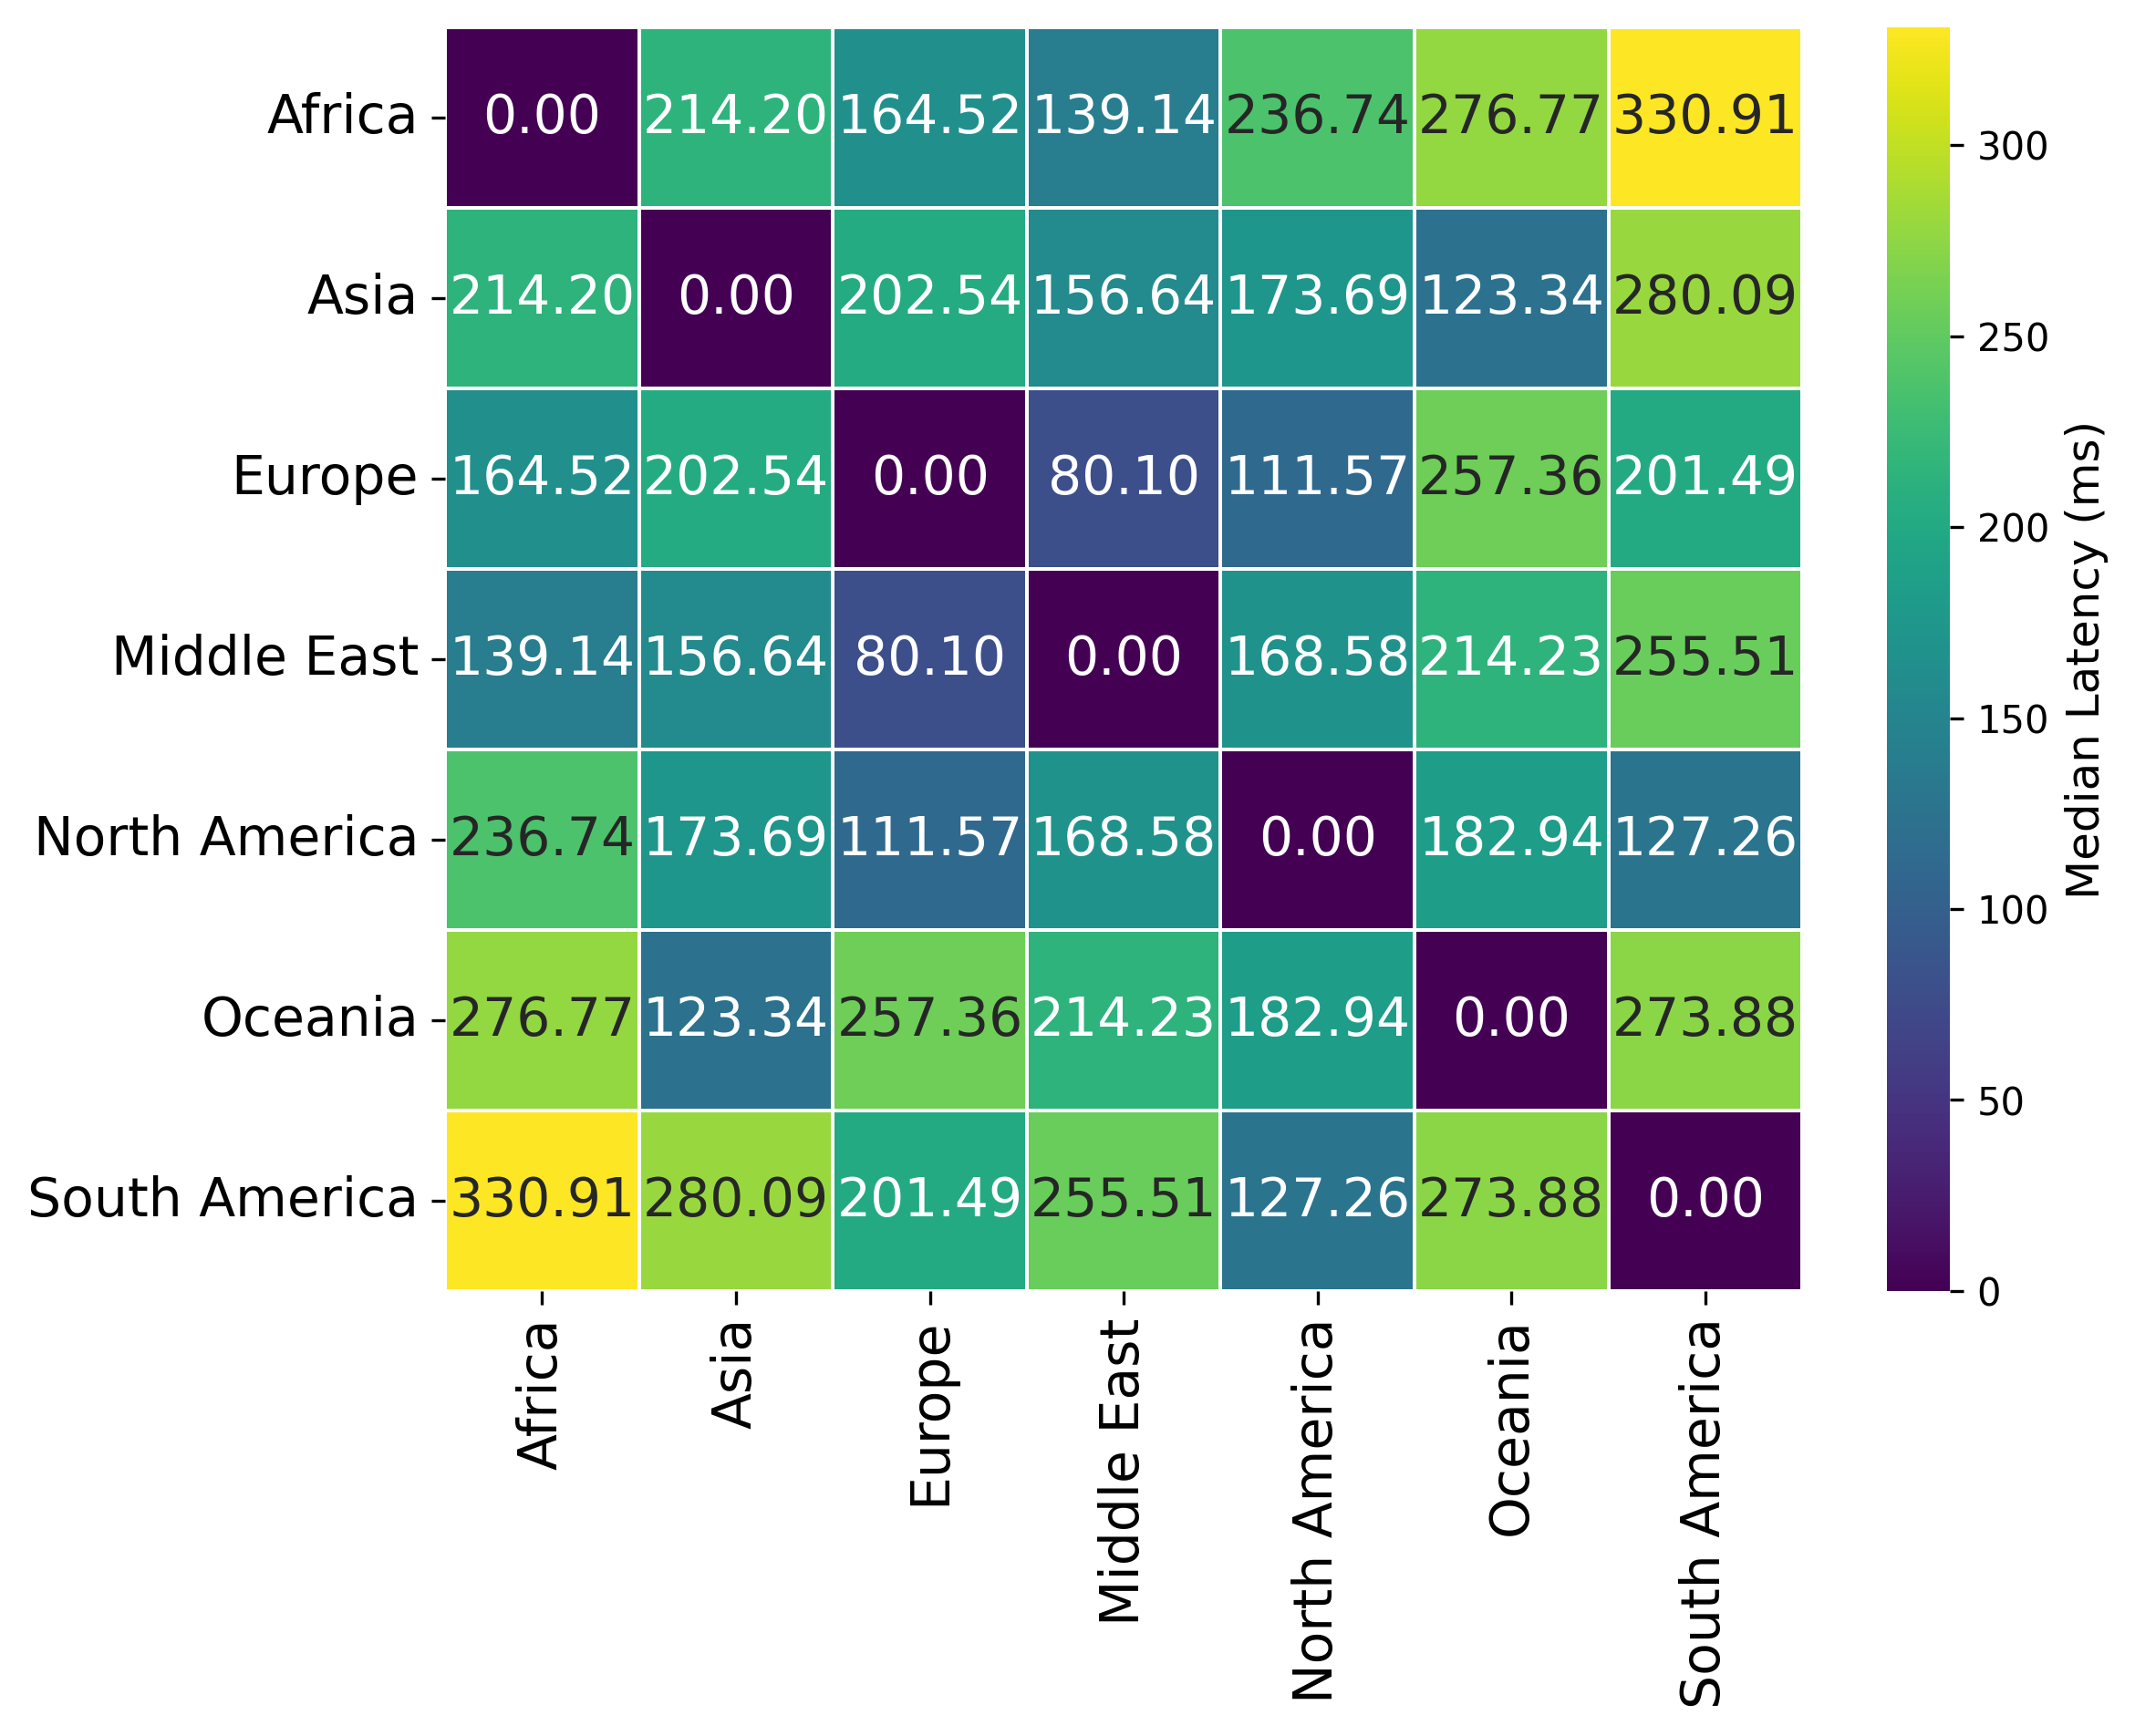

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

_CONTINENT_RULES = [
    (r"^us-|^northamerica-", "North America"),
    (r"^southamerica-",      "South America"),
    (r"^europe-",            "Europe"),
    (r"^asia-",              "Asia"),
    (r"^australia-",         "Oceania"),
    (r"^me-",                "Middle East"),
    (r"^africa-",            "Africa"),
]

def to_continent(region: str) -> str:
    for pat, name in _CONTINENT_RULES:
        if re.match(pat, region):
            return name
    return "Other"


regions = pd.read_csv("data/gcp_regions.csv")
latency = pd.read_csv("data/gcp_latency.csv")


def convert_to_marco_regions(
    regions,
    latency
):
    reg_ids = set(regions["Region"])
    latency = latency[
        latency["sending_region"].isin(reg_ids) &
        latency["receiving_region"].isin(reg_ids)
    ].copy()

    regions["Continent"] = regions["Region"].map(to_continent)
    cont_map = dict(zip(regions["Region"], regions["Continent"]))
    latency["from_c"] = latency["sending_region"].map(cont_map)
    latency["to_c"]   = latency["receiving_region"].map(cont_map)

    # Undirected mean per continent pair
    latency["pair"] = latency.apply(
        lambda r: tuple(sorted([r["from_c"], r["to_c"]])), axis=1
    )
    c_lat = latency.groupby("pair")["milliseconds"].median().reset_index()

    # Build symmetric matrix
    mat = {}

    for _, row in c_lat.iterrows():
        a, b = row["pair"]; ms = row["milliseconds"]
        mat[(a, b)] = ms
        mat[(b, a)] = ms

    regions = (
        regions.groupby("Continent")[["Nearest City Longitude", "Nearest City Latitude"]]
        .mean()
        .rename(columns={"Nearest City Longitude": "lon", "Nearest City Latitude": "lat"})
    )

    regions["Nearest City Longitude"] = regions["lon"]
    regions["Nearest City Latitude"] = regions["lat"]
    regions["gcp_region"] = regions.index
    regions["Region"] = regions.index
    regions["Region Name"] = regions.index

    return regions, mat

region_data, latency_dicts = convert_to_marco_regions(regions, latency)


regions_index = region_data.index
total_latency = {}

max_latency = max(latency_dicts.values())
for region in regions_index:
    total_latency[region] = {}
    for other_region in regions_index:
        if region == other_region:
            total_latency[region][other_region] = 0
        else:
            total_latency[region][other_region] = latency_dicts.get((region, other_region), max_latency)
# print(total_latency)
df = pd.DataFrame(total_latency)
# print(df)

plt.figure(figsize=(8, 6), dpi=300)
ax= sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis",linewidth=.5,annot_kws={"size": 14})
# plt.title("Latency Heatmap Between Macro-regions")
cbar = ax.collections[0].colorbar
cbar.set_label("Median Latency (ms)", fontsize=12)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.savefig("latency_heatmap.pdf", dpi=300, bbox_inches="tight")

In [5]:
for i, row in df.iterrows():
    print(i, row.mean())

Africa 194.61149999999998
Asia 164.3565
Europe 145.3685
Middle East 144.885
North America 142.96892857142856
Oceania 189.78878571428572
South America 209.87678571428572
